In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
import matplotlib.colors as colors

import numpy as np
from numpy.lib.stride_tricks import sliding_window_view 

import tqdm
import collections
try:
    import cPickle as pickle
except:
    import pickle

import setigen as stg
import blscint as bls
from blscint.observations.organization import DSFile, DSPointing, DSCadence
from blscint.remote import dsc_cadence 

import scipy.special
import scipy.stats
from astropy.stats import sigma_clip

from astropy import units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord

import pandas as pd
import sqlite3

import jort
import os
import copy
import shutil
import psutil
from pathlib import Path
import contextlib
import subprocess

# import survey_direction_filter as sdf

DATA_DIR = Path("/datax2/users/bryanb")
DB_PATH = DATA_DIR / "pipeline.sqlite3"
DIAGSTAT_DIR = DATA_DIR / "scintillation_diagstats"
FIGURES_DIR = Path("/home/bryanb/scintillation_project/scintillation_search_paper/scintillation-search-paper/figures/")

model_frame = stg.Frame.from_backend_params(fchans=256, 
                                            obs_length=600,
                                            int_factor=7)
model_frame.get_params()

{'fchans': 256,
 'tchans': 239,
 'df': 2.7939677238464355,
 'dt': 2.505397589333333,
 'fch1': 6000000000.0,
 'ascending': False}

In [3]:
%matplotlib inline

Example of a count stars estimate for a C-band beamwidth (about 6 GHz):

In [3]:
bls.count_stars(0, 0, 2.1, 8.5, r_n=16, t_n=64, d_n=1024, d_sampling_type='carrollostlie', galcen_distance=8.5,)

183228.67291925428

More accurate estimate, though it takes longer:

In [4]:
bls.count_stars(0, 0, 2.1, 8.5, r_n=64, t_n=64, d_n=1024)

174507.8596153854

In [5]:
df_gp = pd.read_csv('galactic_plane_pointings.txt', delim_whitespace=True)
df_gc = pd.read_csv('galactic_center_pointings.txt', delim_whitespace=True)
df_gp.shape, df_gc.shape

((55, 3), (19, 3))

In [6]:
df_gc[['GLON', 'GLAT']] = df_gc.apply(lambda row: bls.to_galactic(row['RA'], row['DEC']), axis=1, result_type='expand')
df_gc.head()

,NAME,RA,DEC,GLON,GLAT
0,DIAG_SCINT_GC_A00,17:45:40.04,-29:00:28.10,-0.055740,-0.046162
1,DIAG_SCINT_GC_C01,17:45:51.95,-28:56:11.99,0.027602,-0.046177
2,DIAG_SCINT_GC_C07,17:45:28.12,-29:04:44.14,-0.139069,-0.046167
3,DIAG_SCINT_GC_B01,17:45:45.99,-28:58:20.05,-0.014081,-0.046147
4,DIAG_SCINT_GC_B04,17:45:34.08,-29:02:36.13,-0.097409,-0.046158


In [7]:
df_gp[['RA', 'DEC']] = df_gp.apply(lambda row: SkyCoord(*bls.to_ra_dec(row['GLON'], row['GLAT']), 
                                                        unit=(u.deg, u.deg))
                                               .to_string('hmsdms', sep=':', precision=2)
                                               .split(), 
                                   axis=1, 
                                   result_type='expand')
df_gp.head()

,NAME,GLON,GLAT,RA,DEC
0,DIAG_SCINT_GP_L-5_B2,-5,2,17:25:15.86,-32:03:46.66
1,DIAG_SCINT_GP_L-4_B2,-4,2,17:27:52.95,-31:13:59.85
2,DIAG_SCINT_GP_L-3_B2,-3,2,17:30:27.15,-30:24:00.12
3,DIAG_SCINT_GP_L-2_B2,-2,2,17:32:58.59,-29:33:48.06
4,DIAG_SCINT_GP_L-1_B2,-1,2,17:35:27.41,-28:43:24.26


In [ ]:
df_full = pd.concat([df_gp, df_gc], ignore_index=True)
df_full['StarCount'] = df_full.apply(lambda row: bls.count_stars(row['GLON'], row['GLAT'], 2.1, 8.5, r_n=10, t_n=100, d_n=1000, d_sampling_type='carrollostlie', galcen_distance=8.5,), axis=1)
df_full

In [8]:
df_full = pd.concat([df_gp, df_gc], ignore_index=True)
df_full['StarCount'] = df_full.apply(lambda row: bls.count_stars(row['GLON'], row['GLAT'], 2.1, 8.5, r_n=16, t_n=64, d_n=1024, d_sampling_type='carrollostlie', galcen_distance=8.5,), axis=1)
df_full 

,NAME,GLON,GLAT,RA,DEC,StarCount
0,DIAG_SCINT_GP_L-5_B2,-5.000000,2.000000,17:25:15.86,-32:03:46.66,83289.805994
1,DIAG_SCINT_GP_L-4_B2,-4.000000,2.000000,17:27:52.95,-31:13:59.85,86075.852641
2,DIAG_SCINT_GP_L-3_B2,-3.000000,2.000000,17:30:27.15,-30:24:00.12,88665.997168
3,DIAG_SCINT_GP_L-2_B2,-2.000000,2.000000,17:32:58.59,-29:33:48.06,90941.933004
4,DIAG_SCINT_GP_L-1_B2,-1.000000,2.000000,17:35:27.41,-28:43:24.26,92711.388840
...,...,...,...,...,...,...
69,DIAG_SCINT_GC_C06,-0.118235,-0.010090,17:45:22.65,-29:02:32.42,183500.251251
70,DIAG_SCINT_GC_C11,-0.014079,-0.118324,17:46:02.90,-29:00:35.29,178875.315046
71,DIAG_SCINT_GC_C09,-0.097401,-0.118343,17:45:51.00,-29:04:51.46,178841.980500
72,DIAG_SCINT_GC_C10,-0.055743,-0.118327,17:45:56.95,-29:02:43.38,178863.567944


In [9]:
# df_full.to_csv('full_counts.txt')

In [8]:
df_full = pd.read_csv('full_counts.txt', index_col=0)
df_full.head()

,NAME,GLON,GLAT,RA,DEC,StarCount
0,DIAG_SCINT_GP_L-5_B2,-5.0,2.0,17:25:15.86,-32:03:46.66,83289.805994
1,DIAG_SCINT_GP_L-4_B2,-4.0,2.0,17:27:52.95,-31:13:59.85,86075.852641
2,DIAG_SCINT_GP_L-3_B2,-3.0,2.0,17:30:27.15,-30:24:00.12,88665.997168
3,DIAG_SCINT_GP_L-2_B2,-2.0,2.0,17:32:58.59,-29:33:48.06,90941.933004
4,DIAG_SCINT_GP_L-1_B2,-1.0,2.0,17:35:27.41,-28:43:24.26,92711.388840


In [10]:
# df_full.style.format({'GLON': '{:.3f}', 'GLAT': '{:.3f}'})
latex_table = df_full.to_latex(formatters={
                                   'GLON': '{:.3f}', 
                                   'GLAT': '{:.3f}',
                                   'StarCount': lambda x: f'{float(f"{x:.3g}"):g}'
                               }, 
                               escape=True,
                               index=False)
print(latex_table)

\begin{tabular}{lrrllr}
\toprule
NAME & GLON & GLAT & RA & DEC & StarCount \\
\midrule
DIAG\_SCINT\_GP\_L-5\_B2 & -5.000 & 2.000 & 17:25:15.86 & -32:03:46.66 & 83300 \\
DIAG\_SCINT\_GP\_L-4\_B2 & -4.000 & 2.000 & 17:27:52.95 & -31:13:59.85 & 86100 \\
DIAG\_SCINT\_GP\_L-3\_B2 & -3.000 & 2.000 & 17:30:27.15 & -30:24:00.12 & 88700 \\
DIAG\_SCINT\_GP\_L-2\_B2 & -2.000 & 2.000 & 17:32:58.59 & -29:33:48.06 & 90900 \\
DIAG\_SCINT\_GP\_L-1\_B2 & -1.000 & 2.000 & 17:35:27.41 & -28:43:24.26 & 92700 \\
DIAG\_SCINT\_GP\_L0\_B2 & 0.000 & 2.000 & 17:37:53.70 & -27:52:49.27 & 93600 \\
DIAG\_SCINT\_GP\_L1\_B2 & 1.000 & 2.000 & 17:40:17.60 & -27:02:03.61 & 92700 \\
DIAG\_SCINT\_GP\_L2\_B2 & 2.000 & 2.000 & 17:42:39.20 & -26:11:07.80 & 90900 \\
DIAG\_SCINT\_GP\_L3\_B2 & 3.000 & 2.000 & 17:44:58.61 & -25:20:02.30 & 88700 \\
DIAG\_SCINT\_GP\_L4\_B2 & 4.000 & 2.000 & 17:47:15.94 & -24:28:47.58 & 86100 \\
DIAG\_SCINT\_GP\_L5\_B2 & 5.000 & 2.000 & 17:49:31.27 & -23:37:24.09 & 83300 \\
DIAG\_SCINT\_GP\_L-5\_B

In [10]:
t_ds = np.zeros(shape=(len(df_full), 3))
for i, row in tqdm.tqdm(df_full.iterrows(), total=len(df_full)):
    l, b = row['GLON'], row['GLAT']

    # Load sampler if exists, otherwise create and save sampler to disk
    try:
        sampler = bls.NESampler.load(f"map_samplers/{l:.2f}_{b:.2f}.pickle")
    except (FileNotFoundError, ModuleNotFoundError, EOFError):
        delta_d = 0.1
        sampler = bls.NESampler(l=l, b=b, d=(delta_d, 20), delta_d=delta_d)
        sampler.save(f"map_samplers/{l:.2f}_{b:.2f}.pickle")
        
    data = sampler.sample(n=10000, 
                            f=(3.95, 8),
                            v=(10, 150),
                            d_sampling_type='carrollostlie')
    t_ds[i, :] = np.quantile(data.t_d, [0.25, 0.50, 0.75])
    
df_full['Q1'] = t_ds[:, 0]
df_full['Median (Q2)'] = t_ds[:, 1]
df_full['Q3'] = t_ds[:, 2]

100%|█████████████████████████████████████████████████████████████████████████████████████████| 74/74 [19:06<00:00, 15.50s/it]


In [12]:
# df_full.style.format({'GLON': '{:.3f}', 'GLAT': '{:.3f}'})
latex_table = df_full.to_latex(formatters={
                                   'GLON': '{:.3f}', 
                                   'GLAT': '{:.3f}',
                                   'StarCount': lambda x: f'{float(f"{x:.3g}"):g}',
                                   'Q1': '{:.1f}', 
                                   'Median (Q2)': '{:.1f}',
                                   'Q3': '{:.1f}',
                               }, 
                               escape=True,
                               index=False)
print(latex_table)

\begin{tabular}{lrrllrrrr}
\toprule
NAME & GLON & GLAT & RA & DEC & StarCount & Q1 & Median (Q2) & Q3 \\
\midrule
DIAG\_SCINT\_GP\_L-5\_B2 & -5.000 & 2.000 & 17:25:15.86 & -32:03:46.66 & 83300 & 32.6 & 52.0 & 106.3 \\
DIAG\_SCINT\_GP\_L-4\_B2 & -4.000 & 2.000 & 17:27:52.95 & -31:13:59.85 & 86100 & 32.6 & 51.3 & 102.0 \\
DIAG\_SCINT\_GP\_L-3\_B2 & -3.000 & 2.000 & 17:30:27.15 & -30:24:00.12 & 88700 & 32.4 & 50.7 & 102.9 \\
DIAG\_SCINT\_GP\_L-2\_B2 & -2.000 & 2.000 & 17:32:58.59 & -29:33:48.06 & 90900 & 32.6 & 50.6 & 102.7 \\
DIAG\_SCINT\_GP\_L-1\_B2 & -1.000 & 2.000 & 17:35:27.41 & -28:43:24.26 & 92700 & 32.6 & 51.0 & 103.6 \\
DIAG\_SCINT\_GP\_L0\_B2 & 0.000 & 2.000 & 17:37:53.70 & -27:52:49.27 & 93600 & 32.4 & 50.2 & 101.0 \\
DIAG\_SCINT\_GP\_L1\_B2 & 1.000 & 2.000 & 17:40:17.60 & -27:02:03.61 & 92700 & 32.7 & 51.1 & 101.6 \\
DIAG\_SCINT\_GP\_L2\_B2 & 2.000 & 2.000 & 17:42:39.20 & -26:11:07.80 & 90900 & 32.0 & 50.6 & 103.1 \\
DIAG\_SCINT\_GP\_L3\_B2 & 3.000 & 2.000 & 17:44:58.61 & -25:

In [238]:
x = 67800
def scinot(num):
    exp = int(np.log10(num))
    lead = np.round(num / 10**exp, 1)
    return f'${lead} \\times 10^{exp}$'

for x in [12300, 457800]:
    print(scinot(x))

$1.2 \times 10^4$
$4.6 \times 10^5$


In [239]:
# df_full.style.format({'GLON': '{:.3f}', 'GLAT': '{:.3f}'})
latex_table = df_full.to_latex(formatters={
                                   'GLON': '{:.3f}', 
                                   'GLAT': '{:.3f}',
                                   'StarCount': lambda x: scinot(x),
                                   'Q1': lambda x: f'{float(f"{x:.3g}"):g}', 
                                   'Median (Q2)': lambda x: f'{float(f"{x:.3g}"):g}',
                                   'Q3': lambda x: f'{float(f"{x:.3g}"):g}',
                               }, 
                               escape=True,
                               index=False)
print(latex_table)

\begin{tabular}{lrrllrrrr}
\toprule
NAME & GLON & GLAT & RA & DEC & StarCount & Q1 & Median (Q2) & Q3 \\
\midrule
DIAG\_SCINT\_GP\_L-5\_B2 & -5.000 & 2.000 & 17:25:15.86 & -32:03:46.66 & $8.3 \times 10^4$ & 32.6 & 52 & 106 \\
DIAG\_SCINT\_GP\_L-4\_B2 & -4.000 & 2.000 & 17:27:52.95 & -31:13:59.85 & $8.6 \times 10^4$ & 32.6 & 51.3 & 102 \\
DIAG\_SCINT\_GP\_L-3\_B2 & -3.000 & 2.000 & 17:30:27.15 & -30:24:00.12 & $8.9 \times 10^4$ & 32.4 & 50.7 & 103 \\
DIAG\_SCINT\_GP\_L-2\_B2 & -2.000 & 2.000 & 17:32:58.59 & -29:33:48.06 & $9.1 \times 10^4$ & 32.6 & 50.6 & 103 \\
DIAG\_SCINT\_GP\_L-1\_B2 & -1.000 & 2.000 & 17:35:27.41 & -28:43:24.26 & $9.3 \times 10^4$ & 32.6 & 51 & 104 \\
DIAG\_SCINT\_GP\_L0\_B2 & 0.000 & 2.000 & 17:37:53.70 & -27:52:49.27 & $9.4 \times 10^4$ & 32.4 & 50.2 & 101 \\
DIAG\_SCINT\_GP\_L1\_B2 & 1.000 & 2.000 & 17:40:17.60 & -27:02:03.61 & $9.3 \times 10^4$ & 32.7 & 51.1 & 102 \\
DIAG\_SCINT\_GP\_L2\_B2 & 2.000 & 2.000 & 17:42:39.20 & -26:11:07.80 & $9.1 \times 10^4$ & 32 & 

### Fine maps

In [5]:
fine_l = np.arange(10, -10-0.25, -0.25)
fine_b = np.arange(5, -5-0.25, -0.25)

In [ ]:
fine_map = np.zeros(shape=(len(fine_b), len(fine_l), 3))
with tqdm.tqdm(total=len(fine_b)*len(fine_l), leave=False) as pbar:
    for b_idx in range(len(fine_b)):
        for l_idx in range(len(fine_l)):
            l, b = fine_l[l_idx], fine_b[b_idx]
            # Load sampler if exists, otherwise create and save sampler to disk
            try:
                sampler = bls.NESampler.load(f"map_samplers/{l:.2f}_{b:.2f}.pickle")
            except (FileNotFoundError, ModuleNotFoundError, EOFError):
                delta_d = 0.1
                sampler = bls.NESampler(l=l, b=b, d=(delta_d, 20), delta_d=delta_d)
                sampler.save(f"map_samplers/{l:.2f}_{b:.2f}.pickle")
            try:
                data = sampler.sample(n=10000, 
                                    f=(3.95, 8),
                                    v=(10, 150),
                                    d_sampling_type='carrollostlie')
                fine_map[b_idx, l_idx, :] = np.quantile(data.t_d, [0.25, 0.50, 0.75])
            except RuntimeError:
                fine_map[b_idx, l_idx, :] = np.nan
            pbar.update(1)
np.save('fine_map_abs.npy', fine_map)

In [6]:
fine_map = np.load('fine_map_abs.npy')

#### Quartile maps (Q1, Q2, Q3)

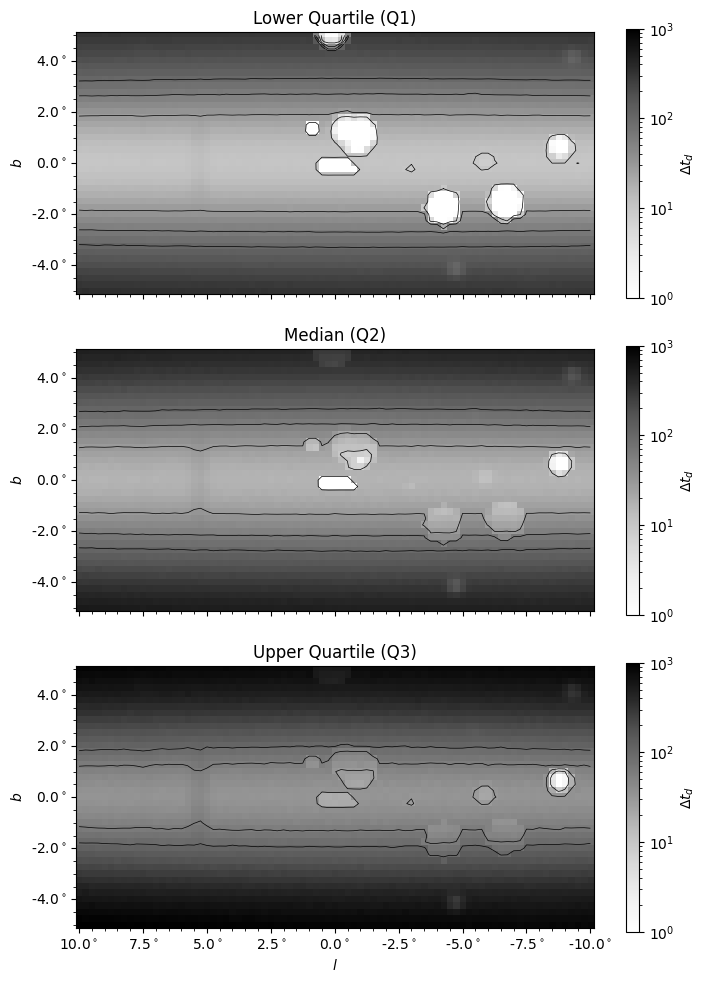

In [23]:
cmap = 'Greys'
vmin = 1
vmax = 1000
extent = [10.125, -10.125, -5.125, 5.125]
levels = [10, 30, 60, 100]
countour_colors = 'black'
# countour_colors = ['blue', 'yellow', 'red', 'black']
linewidths = 0.5
# linestyles = ['dotted', 'dashed', 'dashdot', 'solid']
marker = 'o'
markersize = 1
show_countours = True
show_targets = False

# prop_cycle = plt.rcParams['axes.prop_cycle']
# countour_colors = prop_cycle.by_key()['color']

# countour_colors = None
linestyles = None


pointing_grid_l = np.arange(5, -5-1, -1)
pointing_grid_b = np.arange(2, -2-1, -1)
p_X, p_Y = np.meshgrid(pointing_grid_l, pointing_grid_b)

# Find pointings that probe dense regions
dense_scattering = [[], []]
for l in pointing_grid_l:
    i = np.digitize(l, fine_l)
    for b in pointing_grid_b:
        j = np.digitize(b, fine_b)
        if fine_map[:,:,0][j][i] <= 10:
            dense_scattering[0].append(l)
            dense_scattering[1].append(b)


fig = plt.figure(figsize=(8, 10))

gs = grd.GridSpec(3, 1)

ax = plt.subplot(gs[0, 0])
p = ax.imshow(fine_map[:,:,0], 
              extent=extent,
              aspect='equal',
              interpolation='none',
              # vmin=10,
              # vmax=1000,
              norm=colors.LogNorm(vmin=vmin, vmax=vmax),
              cmap=cmap)
if show_countours:
    CS = ax.contour(fine_l, 
                    fine_b, 
                    fine_map[:,:,0], 
                    levels=levels, 
                    colors=countour_colors, 
                    linewidths=linewidths,
                    linestyles=linestyles)
    # cl = ax.clabel(CS, inline=1, manual=[
    #     # [0.0, 4.7], 
    #     [-0.5, 1.82], 
    #     [-8.75, 0.1], 
    #     [-5.92, -0.25], 
    #     # [-0.75, -0.46], 
    #     [-0., -0.33],
    #     [-4.25, -0.99], 
    #     [-6.25, -2.05], 
    #     # [0.0, 4.56], 
    #     [-8.0, 1.88], 
    #     [8.0, -1.86], 
    #     # [0.0, 4.47], 
    #     [0.5, 2.7], 
    #     [-0.5, -2.69], 
    #     [0.0, 4.4], 
    #     [-7.5, 3.26], 
    #     [6.75, -3.25]
    # ])

if show_targets:
    ax.scatter(p_X, p_Y, c='cyan', marker=marker, s=markersize, zorder=20)
    ax.scatter(dense_scattering[0], dense_scattering[1], c='blue', marker=marker, s=markersize, zorder=30)

ax.tick_params(axis='x', labelbottom=False)
plt.minorticks_on()
ax.yaxis.set_major_formatter(lambda y, pos: rf"{y:.1f}$^\circ$")
cbar = fig.colorbar(p)
cbar.ax.set_ylabel(r"$\Delta t_d$")

ax.set_ylabel(r"$b$")
# ax.set_title(r"25% quartile for $\Delta t_d$")
ax.set_title(r"Lower Quartile (Q1)")


ax = plt.subplot(gs[1, 0])
p = ax.imshow(fine_map[:,:,1], 
              extent=extent,
              aspect='equal',
              interpolation='none',
              # vmin=10,
              # vmax=1000,
              norm=colors.LogNorm(vmin=vmin, vmax=vmax),
              cmap=cmap)
if show_countours:
    # CS = ax.contour(fine_l[:], fine_b[:], fine_map[:,:,1], levels=levels, colors='k', linewidths=1)
    # cl = ax.clabel(CS, inline=1, manual=[
    #     [-1.17, 0.5], 
    #     [-8.75, 0.1], 
    #     # [-0.75, -0.38],
    #     [-0., -0.33],
    #     [-8.0, 1.3], 
    #     [0.0, -1.31], 
    #     [-3.75, 2.18], 
    #     [8.0, -2.1], 
    #     [4.58, 2.75], 
    #     [6.75, -2.7]
    # ])
    CS = ax.contour(fine_l, 
                    fine_b, 
                    fine_map[:,:,1], 
                    levels=levels, 
                    colors=countour_colors, 
                    linewidths=linewidths,
                    linestyles=linestyles)

if show_targets:
    ax.scatter(p_X, p_Y, c='cyan', marker=marker, s=markersize, zorder=20)
    ax.scatter(dense_scattering[0], dense_scattering[1], c='blue', marker=marker, s=markersize, zorder=30)

ax.tick_params(axis='x', labelbottom=False)
plt.minorticks_on()
ax.yaxis.set_major_formatter(lambda y, pos: rf"{y:.1f}$^\circ$")
cbar = fig.colorbar(p)
cbar.ax.set_ylabel(r"$\Delta t_d$")

ax.set_ylabel(r"$b$")
# ax.set_title(r"50% quartile for $\Delta t_d$")
ax.set_title(r"Median (Q2)")


ax = plt.subplot(gs[2, 0])
p = ax.imshow(fine_map[:,:,2], 
              extent=extent,
              aspect='equal',
              interpolation='none',
              # vmin=10,
              # vmax=1000,
              norm=colors.LogNorm(vmin=vmin, vmax=vmax),
              cmap=cmap)
if show_countours:
    # CS = ax.contour(fine_l[:], fine_b[:], fine_map[:,:,2], levels=levels, colors='k', linewidths=1)
    # cl = ax.clabel(CS, inline=1, manual=[
    #     [-8.75, 0.1], 
    #     [-1.25, 0.36], 
    #     # [-9.2, 0.25], 
    #     [-6.04, -0.25], 
    #     # [-0.75, -0.39], 
    #     [-0., -0.33],
    #     [-5.98, 1.25], 
    #     [1.25, -1.32], 
    #     [6.25, 1.95], 
    #     [6.75, -1.89]
    # ])
    CS = ax.contour(fine_l, 
                    fine_b, 
                    fine_map[:,:,2], 
                    levels=levels, 
                    colors=countour_colors, 
                    linewidths=linewidths,
                    linestyles=linestyles)

if show_targets:
    ax.scatter(p_X, p_Y, c='cyan', marker=marker, s=markersize, zorder=20)
    ax.scatter(dense_scattering[0], dense_scattering[1], c='blue', marker=marker, s=markersize, zorder=30)

plt.minorticks_on()
ax.xaxis.set_major_formatter(lambda x, pos: rf"{x:.1f}$^\circ$")
ax.yaxis.set_major_formatter(lambda y, pos: rf"{y:.1f}$^\circ$")
cbar = fig.colorbar(p)
cbar.ax.set_ylabel(r"$\Delta t_d$")

ax.set_xlabel(r"$l$")
ax.set_ylabel(r"$b$")
# ax.set_title(r"75% quartile for $\Delta t_d$")
ax.set_title(r"Upper Quartile (Q3)")


fig.align_labels()
fig.tight_layout()

plt.savefig(FIGURES_DIR / 'timescale_quartile_map.pdf', bbox_inches='tight')
plt.show()

In [ ]:
t_d_min = 10
t_d_max = 100

coverage_map = np.zeros(shape=(len(fine_b), len(fine_l)))
with tqdm.tqdm(total=len(fine_b)*len(fine_l), leave=False) as pbar:
    for b_idx in range(len(fine_b)):
        for l_idx in range(len(fine_l)):
            l, b = fine_l[l_idx], fine_b[b_idx]
            sampler = bls.NESampler.load(f"map_samplers/{l:.2f}_{b:.2f}.pickle")
            try:
                data = sampler.sample(n=10000, 
                                    f=(3.95, 8),
                                    v=(10, 150),
                                    d_sampling_type='carrollostlie')
                coverage_map[b_idx, l_idx] = np.sum((data.t_d >= t_d_min) & (data.t_d <= t_d_max)) / 10000
            except RuntimeError:
                coverage_map[b_idx, l_idx] = np.nan
            pbar.update(1)
np.save('coverage_map_abs_10_100.npy', coverage_map)

In [3]:
coverage_map = np.load('coverage_map_abs_10_100.npy')

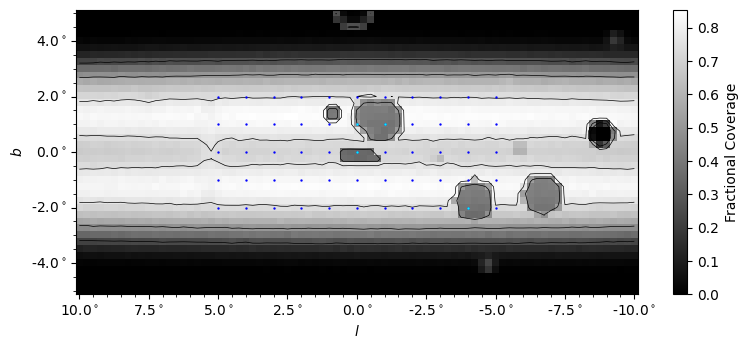

In [24]:
t_d_min = 10
t_d_max = 100

cmap = 'gray'
vmin = 0
vmax = 1
extent = [10.125, -10.125, -5.125, 5.125]
levels = [0.25, 0.5, 0.75]
countour_colors = 'black'
linewidths = 0.5
linestyles = ['dotted', 'dashed', 'dashdot', 'solid']
marker = 'o'
markersize = 0.5
show_countours = True
show_targets = True

linestyles = None

pointing_grid_l = np.arange(5, -5-1, -1)
pointing_grid_b = np.arange(2, -2-1, -1)
p_X, p_Y = np.meshgrid(pointing_grid_l, pointing_grid_b)

# Find pointings that probe dense regions
dense_scattering = [[], []]
for l in pointing_grid_l:
    i = np.digitize(l, fine_l) 
    for b in pointing_grid_b:
        j = np.digitize(b, fine_b) 
        if fine_map[:,:,0][j][i] <= 10:
            dense_scattering[0].append(l)
            dense_scattering[1].append(b)


fig = plt.figure(figsize=(8, 3.5))
# fig = plt.figure(figsize=(6, 2.5))

gs = grd.GridSpec(1, 1)

ax = plt.subplot(gs[0, 0])
p = ax.imshow(coverage_map[:,:], 
              extent=extent,
              aspect='equal',
              interpolation='none', #vmin=vmin, vmax=vmax,
              # vmin=10,
              # vmax=1000,
            #   norm=colors.LogNorm(vmin=vmin, vmax=vmax),
              cmap=cmap)
if show_countours:
    CS = ax.contour(fine_l[:], 
                    fine_b[:], 
                    coverage_map[:,:], 
                    levels=levels, 
                    colors=countour_colors, 
                    linewidths=linewidths, 
                    linestyles=linestyles)
    # cl = ax.clabel(CS, inline=True, fontsize='smaller', 
    #           )
    # cl = ax.clabel(CS, 
    #                inline=True, 
    #                fontsize='smaller', 
    #                manual=[
    #                    [1.5, 3.32],
    #                    [-1.0, -3.3],
    #                    [7.0, 2.7],
    #                    [7.0, -2.73],
    #                    [-1.0, 0.41],
    #                    [-0., -0.33],
    #                    [-6.77, -2.25],
    #                    [-4.5, -2.39],
    #                    [3.5, 0.43],
    #                    [-6.75, 1.95],
    #                    [-3.75, -0.51],
    #                    [8.75, -1.82]
    #                ])

if show_targets:
    ax.scatter(p_X, p_Y, c='blue', marker=marker, s=markersize, zorder=20)
    ax.scatter(dense_scattering[0], dense_scattering[1], c='cyan', marker=marker, s=markersize, zorder=30)

plt.minorticks_on()
ax.xaxis.set_major_formatter(lambda x, pos: rf"{x:.1f}$^\circ$")
ax.yaxis.set_major_formatter(lambda y, pos: rf"{y:.1f}$^\circ$")
cbar = fig.colorbar(p)
cbar.ax.set_ylabel('Fractional Coverage')

ax.set_xlabel(r"$l$")
ax.set_ylabel(r"$b$")
# ax.set_title(rf"Fractional Coverage for ${int(t_d_min)} \leq \Delta t_d \leq {int(t_d_max)}$")

fig.align_labels()
fig.tight_layout()

plt.savefig(FIGURES_DIR / 'timescale_coverage_map.pdf', bbox_inches='tight')
plt.show()



In [208]:
np.max(coverage_map)

0.8538

In [222]:
fine_b[20]

0.0

In [210]:
coverage_map[20,:]

array([0.6758, 0.6813, 0.6824, 0.6855, 0.6771, 0.6824, 0.6841, 0.6907,
       0.6848, 0.6856, 0.6918, 0.6983, 0.6906, 0.6903, 0.6956, 0.7006,
       0.7005, 0.7124, 0.7405, 0.748 , 0.7264, 0.7013, 0.7125, 0.7116,
       0.7054, 0.7053, 0.706 , 0.7057, 0.7148, 0.7129, 0.7129, 0.7176,
       0.7132, 0.709 , 0.7182, 0.7149, 0.7157, 0.719 , 0.3582, 0.3465,
       0.3536, 0.3537, 0.3466, 0.7142, 0.7125, 0.716 , 0.7121, 0.71  ,
       0.7213, 0.7141, 0.7113, 0.7047, 0.7043, 0.7139, 0.7036, 0.7079,
       0.7024, 0.7085, 0.7099, 0.7044, 0.7044, 0.7085, 0.699 , 0.5941,
       0.5986, 0.6979, 0.6978, 0.7001, 0.6963, 0.6956, 0.6987, 0.6949,
       0.6928, 0.6905, 0.6914, 0.6787, 0.6801, 0.6772, 0.6732, 0.6757,
       0.6795])

In [217]:
fine_b[12]

2.0

In [218]:
coverage_map[12,:]

array([0.7113, 0.7113, 0.7156, 0.7127, 0.7181, 0.7152, 0.7246, 0.7302,
       0.7268, 0.7143, 0.6988, 0.7134, 0.7244, 0.7295, 0.7293, 0.7253,
       0.7294, 0.7319, 0.7287, 0.7287, 0.729 , 0.7424, 0.7335, 0.7394,
       0.7449, 0.7382, 0.7394, 0.7402, 0.7367, 0.7377, 0.7477, 0.7497,
       0.7453, 0.7476, 0.75  , 0.7517, 0.7513, 0.7471, 0.7469, 0.7435,
       0.7499, 0.7672, 0.7811, 0.7428, 0.7436, 0.7504, 0.7471, 0.7444,
       0.7438, 0.745 , 0.7419, 0.7371, 0.7399, 0.7391, 0.7444, 0.7418,
       0.7459, 0.744 , 0.7365, 0.7411, 0.7376, 0.7371, 0.7381, 0.7327,
       0.7399, 0.7364, 0.736 , 0.7306, 0.7324, 0.7306, 0.7292, 0.7328,
       0.7292, 0.7307, 0.7268, 0.7233, 0.7286, 0.7141, 0.7124, 0.7174,
       0.72  ])

In [220]:
fine_b[16]

1.0

In [221]:
coverage_map[16,:]

array([0.8121, 0.8161, 0.8201, 0.8083, 0.8191, 0.8198, 0.8111, 0.8202,
       0.8178, 0.8167, 0.8187, 0.8126, 0.8249, 0.8194, 0.8216, 0.8227,
       0.8219, 0.814 , 0.817 , 0.8187, 0.818 , 0.8268, 0.8275, 0.8227,
       0.8295, 0.829 , 0.8341, 0.8306, 0.8239, 0.8287, 0.8262, 0.8345,
       0.833 , 0.8309, 0.8301, 0.8314, 0.8275, 0.835 , 0.8351, 0.819 ,
       0.5113, 0.419 , 0.3966, 0.396 , 0.3953, 0.3863, 0.4173, 0.8353,
       0.8285, 0.8335, 0.8288, 0.8305, 0.8321, 0.8341, 0.8341, 0.8378,
       0.8243, 0.8282, 0.8258, 0.8234, 0.8379, 0.8306, 0.8237, 0.8233,
       0.8236, 0.8177, 0.8259, 0.8203, 0.8198, 0.822 , 0.8248, 0.8223,
       0.8163, 0.8153, 0.457 , 0.0826, 0.2   , 0.8441, 0.8149, 0.8191,
       0.8139])

In [7]:
l, b = 1, 0

# Load sampler if exists, otherwise create and save sampler to disk
try:
    sampler = bls.NESampler.load(f"map_samplers/{l:.2f}_{b:.2f}.pickle")
except (FileNotFoundError, ModuleNotFoundError, EOFError):
    delta_d = 0.1
    sampler = bls.NESampler(l=l, b=b, d=(delta_d, 20), delta_d=delta_d)
    sampler.save(f"map_samplers/{l:.2f}_{b:.2f}.pickle")
    
data = sampler.sample(n=10000, 
                        f=(3.95, 8),
                        v=(10, 150),
                        d_sampling_type='carrollostlie')

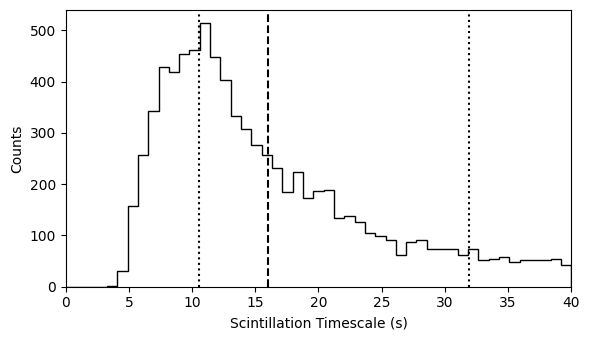

In [12]:
quantity = 't_d'
t_ds = data.data_dict[quantity]
# clipped_data = sigma_clip(data, maxiters=10, masked=False)
# vals, bins = np.histogram(clipped_data, bins=25)
# mode_idx = np.argmax(vals)
# mode = (bins[mode_idx] + bins[mode_idx + 1]) / 2

bins = np.linspace(0, 40, 50)


fig = plt.figure(figsize=(6, 3.5))
plt.hist(t_ds, bins=bins, histtype='step', color='k')
plt.xlabel(f'{data.labels[quantity]} ({data.units[quantity]})')
plt.ylabel('Counts')

plt.axvline(np.median(t_ds), ls='--', c='k')
plt.axvline(np.quantile(t_ds, 0.25), ls=':', c='k')
plt.axvline(np.quantile(t_ds, 0.75), ls=':', c='k')
plt.xlim(0, 40)
plt.tight_layout()

plt.savefig(FIGURES_DIR / 'timescale_l1_b0_example.pdf', bbox_inches='tight')
plt.show()

Do the same thing for the North Galactic Pole, to vet that it's different enough

In [4]:
l, b = 0, 90

# Load sampler if exists, otherwise create and save sampler to disk
try:
    sampler = bls.NESampler.load(f"map_samplers/{l:.2f}_{b:.2f}.pickle")
except (FileNotFoundError, ModuleNotFoundError, EOFError):
    delta_d = 0.1
    sampler = bls.NESampler(l=l, b=b, d=(delta_d, 20), delta_d=delta_d)
    sampler.save(f"map_samplers/{l:.2f}_{b:.2f}.pickle")
    
data = sampler.sample(n=10000, 
                        f=(3.95, 8),
                        v=(10, 150),
                        d_sampling_type='carrollostlie')

quantity = 't_d'
t_ds = data.data_dict[quantity]
# clipped_data = sigma_clip(data, maxiters=10, masked=False)
# vals, bins = np.histogram(clipped_data, bins=25)
# mode_idx = np.argmax(vals)
# mode = (bins[mode_idx] + bins[mode_idx + 1]) / 2

bins = np.linspace(0, 40, 50)


fig = plt.figure(figsize=(6, 3.5))
plt.hist(t_ds, bins=bins, histtype='step', color='k')
plt.xlabel(f'{data.labels[quantity]} ({data.units[quantity]})')
plt.ylabel('Counts')

plt.axvline(np.median(t_ds), ls='--', c='k')
plt.axvline(np.quantile(t_ds, 0.25), ls=':', c='k')
plt.axvline(np.quantile(t_ds, 0.75), ls=':', c='k')
plt.xlim(0, 40)
plt.tight_layout()

plt.savefig(FIGURES_DIR / 'timescale_l0_b90_example.pdf', bbox_inches='tight')
plt.show()

RuntimeError: Strong regime is never achieved along the line of sight!

In [5]:
bls.min_d_ss(0, 90, d=(1e-3, 20), f=(3.95, 8), delta_d=0.1)

In [6]:
bls.query_ne2001(l, b, 2, field='NU_T')

<Quantity 6.35 GHz>

In [7]:
bls.query_ne2001(l, b, 2, field='SCINTIME')

<Quantity 771. s>

100%|██████████████████████████████████████████████████████████████████| 10000/10000 [07:34<00:00, 22.00it/s]


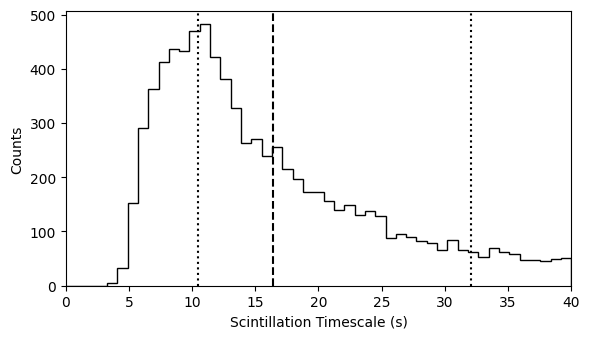

In [23]:
l, b = 1, 0

# Load sampler if exists, otherwise create and save sampler to disk
delta_d = 0.1
sampler = bls.NESampler(l=l, b=b, d=(delta_d, 20), delta_d=delta_d)
# sampler.save(f"map_samplers/{l:.2f}_{b:.2f}.pickle")
    
data = sampler.sample(n=10000, 
                        f=(3.95, 8),
                        v=(10, 150),
                        d_sampling_type='carrollostlie')

quantity = 't_d'
t_ds = data.data_dict[quantity]
# clipped_data = sigma_clip(data, maxiters=10, masked=False)
# vals, bins = np.histogram(clipped_data, bins=25)
# mode_idx = np.argmax(vals)
# mode = (bins[mode_idx] + bins[mode_idx + 1]) / 2

bins = np.linspace(0, 40, 50)


fig = plt.figure(figsize=(6, 3.5))
plt.hist(t_ds, bins=bins, histtype='step', color='k')
plt.xlabel(f'{data.labels[quantity]} ({data.units[quantity]})')
plt.ylabel('Counts')

plt.axvline(np.median(t_ds), ls='--', c='k')
plt.axvline(np.quantile(t_ds, 0.25), ls=':', c='k')
plt.axvline(np.quantile(t_ds, 0.75), ls=':', c='k')
plt.xlim(0, 40)
plt.tight_layout()

# plt.savefig(FIGURES_DIR / 'timescale_l1_b0_example.pdf', bbox_inches='tight')
plt.show()

100%|████████████████████████████████████████████████████████████████| 10000/10000 [1:02:33<00:00,  2.66it/s]


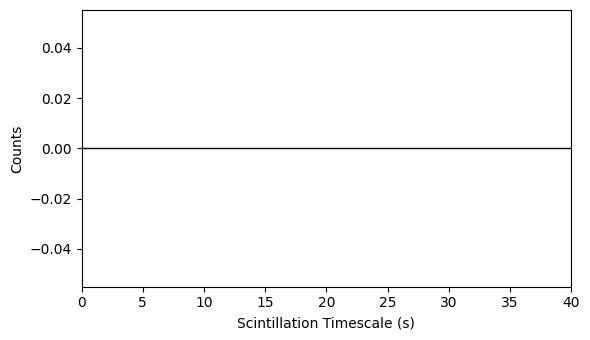

In [24]:
l, b = 0, 90

# Load sampler if exists, otherwise create and save sampler to disk
delta_d = 0.1
sampler = bls.NESampler(l=l, b=b, d=(delta_d, 20), delta_d=delta_d)
# sampler.save(f"map_samplers/{l:.2f}_{b:.2f}.pickle")
    
data = sampler.sample(n=10000, 
                        f=(3.95, 8),
                        v=(10, 150),
                        d_sampling_type='carrollostlie')

quantity = 't_d'
t_ds = data.data_dict[quantity]
# clipped_data = sigma_clip(data, maxiters=10, masked=False)
# vals, bins = np.histogram(clipped_data, bins=25)
# mode_idx = np.argmax(vals)
# mode = (bins[mode_idx] + bins[mode_idx + 1]) / 2

bins = np.linspace(0, 40, 50)


fig = plt.figure(figsize=(6, 3.5))
plt.hist(t_ds, bins=bins, histtype='step', color='k')
plt.xlabel(f'{data.labels[quantity]} ({data.units[quantity]})')
plt.ylabel('Counts')

plt.axvline(np.median(t_ds), ls='--', c='k')
plt.axvline(np.quantile(t_ds, 0.25), ls=':', c='k')
plt.axvline(np.quantile(t_ds, 0.75), ls=':', c='k')
plt.xlim(0, 40)
plt.tight_layout()

# plt.savefig(FIGURES_DIR / 'timescale_l1_b0_example.pdf', bbox_inches='tight')
plt.show()

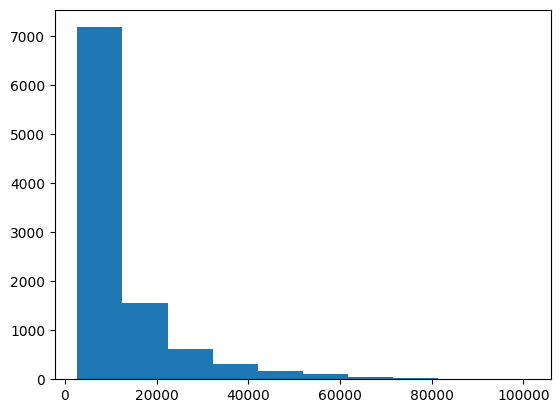

In [27]:
plt.hist(data.t_d)
plt.show()

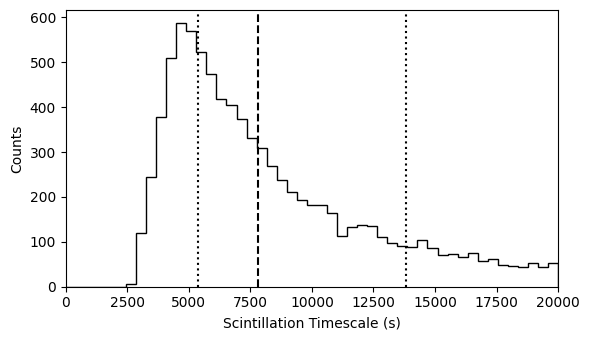

min 2715.4868251538765


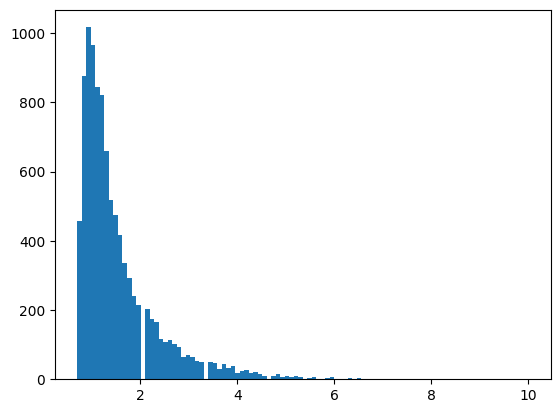

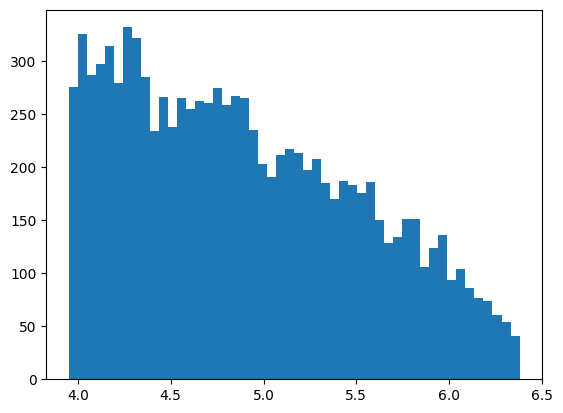

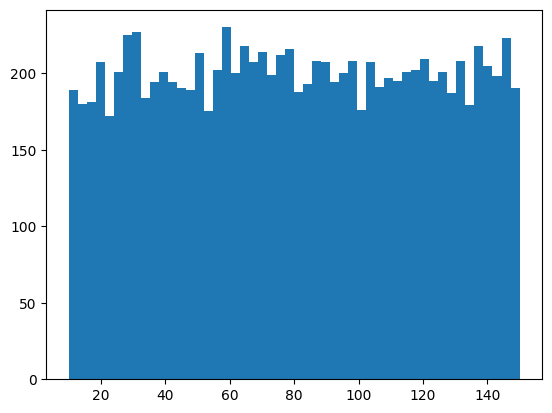

In [36]:
fig = plt.figure(figsize=(6, 3.5))
bins = np.linspace(0, 20000, 50)

plt.hist(data.t_d, bins=bins, histtype='step', color='k')
plt.xlabel(f'{data.labels[quantity]} ({data.units[quantity]})')
plt.ylabel('Counts')

plt.axvline(np.median(data.t_d), ls='--', c='k')
plt.axvline(np.quantile(data.t_d, 0.25), ls=':', c='k')
plt.axvline(np.quantile(data.t_d, 0.75), ls=':', c='k')
plt.xlim(0, 20000)
plt.tight_layout()

plt.savefig(FIGURES_DIR / 'timescale_l0_b90_example.pdf', bbox_inches='tight')
plt.show()

print('min', np.min(data.t_d))

plt.hist(data.d, bins=100)
plt.show()
plt.hist(data.f, bins=50)
plt.show()
plt.hist(data.v, bins=50)
plt.show()

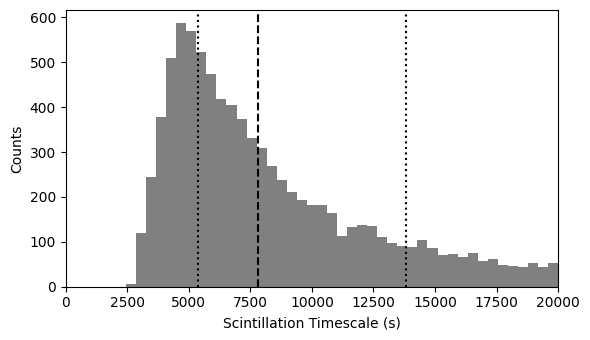

In [46]:
fig = plt.figure(figsize=(6, 3.5))
bins = np.linspace(0, 20000, 50)

plt.hist(data.t_d, bins=bins, color='gray')#, histtype='step', color='k')

# chisq_counts, chisq_bins = np.histogram(data.t_d, bins)

# plt.plot(chisq_bins[1:], chisq_counts)


plt.xlabel(f'{data.labels[quantity]} ({data.units[quantity]})')
plt.ylabel('Counts')
plt.axvline(np.median(data.t_d), ls='--', c='k')
plt.axvline(np.quantile(data.t_d, 0.25), ls=':', c='k')
plt.axvline(np.quantile(data.7t_d, 0.75), ls=':', c='k')
plt.xlim(0, 20000)
plt.tight_layout()

# plt.savefig(FIGURES_DIR / 'timescale_l0_b90_example.pdf', bbox_inches='tight')
plt.show()


In [49]:
# with open('l0_b90_data.pickle', 'wb') as f:
#     pickle.dump(data, f)

with open('l0_b90_data.pickle', 'rb') as f:
    data = pickle.load(f)